In [70]:
from time import time
from collections import Counter
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_validate
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Load train and test data

In [162]:
#Training data
data = pd.read_csv('cardiotocography_train.csv')
print(data.shape[1] - 1,'features and',data.shape[0],'training examples')
data.head()

21 features and 1759 training examples


,LB,AC,FM,UC,ASTV,MSTV,ALTV,MLTV,DL,DS,...,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,NSP
0,130,10,54,1,34,2.1,0,3.0,0,0,...,50,182,8,0,159,151,155,25,1,1
1,120,4,23,5,36,1.5,0,13.5,0,0,...,62,174,6,0,119,129,125,42,0,1
2,133,0,0,4,20,2.7,0,18.5,6,0,...,63,161,7,0,136,124,134,61,1,1
3,136,4,0,5,46,0.8,1,7.4,0,0,...,119,158,1,1,144,143,145,1,0,1
4,130,6,557,6,29,1.7,0,7.8,5,0,...,65,177,6,1,133,129,133,27,0,1


In [158]:
#Validation data
data_validation = pd.read_csv('cardiotocography_validation.csv')
print(data.shape[1] - 1,'features and',data_validation.shape[0],'validation examples')
data_validation.head()

21 features and 367 validation examples


,LB,AC,FM,UC,ASTV,MSTV,ALTV,MLTV,DL,DS,...,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,NSP
0,122,0,0,1,21,2.2,0,17.4,0,0,...,104,143,4,2,129,126,128,4,0,NaN
1,125,8,8,6,21,2.3,0,4.3,8,0,...,67,174,7,0,143,125,134,79,0,NaN
2,130,0,66,0,80,0.3,0,0.0,0,0,...,107,136,1,0,108,120,120,23,-1,NaN
3,125,0,1,8,62,1.7,0,1.1,7,0,...,68,140,5,0,130,116,125,29,1,NaN
4,145,0,1,1,34,1.7,0,25.9,0,0,...,57,166,5,1,150,147,150,10,1,NaN


## Data Preparation

In [79]:
data.isnull().sum()

LB          0
AC          0
FM          0
UC          0
ASTV        0
MSTV        0
ALTV        0
MLTV        0
DL          0
DS          0
DP          0
Width       0
Min         0
Max         0
Nmax        0
Nzeros      0
Mode        0
Mean        0
Median      0
Variance    0
Tendency    0
NSP         0
dtype: int64

In [80]:
data.dtypes

LB            int64
AC            int64
FM            int64
UC            int64
ASTV          int64
MSTV        float64
ALTV          int64
MLTV        float64
DL            int64
DS            int64
DP            int64
Width         int64
Min           int64
Max           int64
Nmax          int64
Nzeros        int64
Mode          int64
Mean          int64
Median        int64
Variance      int64
Tendency      int64
NSP           int64
dtype: object

In [78]:
# Droping the "suspect" class to see if the model performs well under 

In [91]:
data = data[data['NSP'] != 2]

# Data Exploration

In [143]:
data['NSP'].value_counts()

1    1327
2     295
3     137
Name: NSP, dtype: int64

In [164]:
susp_data = data[data['NSP'] == 2]
sups_data.replace(2,3)

TypeError: 'method' object is not subscriptable

## Feature Correlation

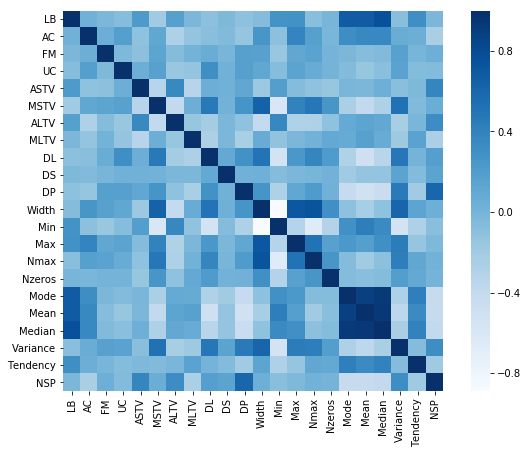

In [154]:
correlation_matrix = data.corr()
fig = plt.figure(figsize=(10, 7))
ax = plt.axes()
ax = sns.heatmap(correlation_matrix, mask=np.zeros_like(correlation_matrix, dtype=np.bool), cmap="Blues", square=True, ax = ax)
plt.show()

## Modeling
### Define features and targets
Specify for the training set which columns contain the features (`X`) and which column contains the target (`y`). Note, that for the validation set we only need to specify the feature columns (`X_validation`) we use for prediction, since the target is not know to us and has to be predicted by our model.

In [149]:
#data = data[data['NSP'] != 2]
X = data[data.columns[:-1]]
X = X[['AC', 'ASTV', 'ALTV', 'DP', 'MLTV']]

y = data[data.columns[-1]]

X_validation = data_validation[data_validation.columns[:-1]]
X_validation = X_validation[['AC', 'ASTV', 'ALTV', 'DP', 'MLTV']]

## Model Selection
Define a list of algorithm classes that should be investigated. For this example, we are only considering a Support Vector Machine with a linear kernel. Feel free to consider more algorithms by importing the respective module and adding the respective model class to the `algorithms` list.

Series([], Name: NSP, dtype: int64)

In [150]:
algorithms = [
    LinearSVC(), 
    RandomForestClassifier(), 
    #AdaBoostClassifier(), 
    #BaggingClassifier(),
    #LogisticRegression(),
    #KNeighborsClassifier(),
    #MLPClassifier()
]

In [155]:
def model_selection(X, y, algorithms, n_splits=10, test_size=.3, train_size=.6, random_state=0):
    """Select the most accurate machine learning model from a given list.

    Parameters
    ----------
    X : array-like
        dataFrame to fit
    y : array-like
        target variable to predict
    algorithms : array-like
        scikit-learn model objects
    n_splits : int
        number of re-shuffling & splitting iterations
    test_size : float, int
        proportion of the dataset to include in the test split
    train_size : float, int
        proportion of the dataset to include in the train split
    random_state : int
        random seed
    
    Returns
    -------
    algorithm_comparision : array-like
        dataframe containing the algorithm's attributes and accuracy 
    """
    # Define the cross-validation split, leaving out 10%
    cv_split = ShuffleSplit(n_splits=n_splits,test_size=test_size,
                            train_size=train_size,random_state=random_state)
    
    # Create a table to compare the algorithm's metrics and predictions
    columns = ['name','params','mean_train_accuracy','mean_test_accuracy','test_accuracy_3std' ,'time']
    algorithm_comparison = pd.DataFrame(columns = columns)

    row_index = 0
    
    for alg in algorithms:

        # Set name and parameters of the algorithm
        algorithm_name = alg.__class__.__name__
        algorithm_comparison.loc[row_index, 'name'] = algorithm_name
        algorithm_comparison.loc[row_index, 'params'] = str(alg.get_params())

        # Score model with cross validation using the accuracy metric
        cv_results = cross_validate(alg, X, y, cv=cv_split, scoring='balanced_accuracy', return_train_score=True)
        algorithm_comparison.loc[row_index, 'time'] = cv_results['fit_time'].mean()
        algorithm_comparison.loc[row_index, 'mean_train_accuracy'] = cv_results['train_score'].mean()
        algorithm_comparison.loc[row_index, 'mean_test_accuracy'] = cv_results['test_score'].mean()  
        algorithm_comparison.loc[row_index, 'test_accuracy_3std'] = cv_results['test_score'].std()*3

        row_index+=1

    algorithm_comparison.sort_values(by = ['mean_test_accuracy'], ascending = False, inplace = True)
    
    return algorithm_comparison

In [156]:
model_selection(X,y,algorithms)

,name,params,mean_train_accuracy,mean_test_accuracy,test_accuracy_3std,time
1,RandomForestClassifier,"{'bootstrap': True, 'class_weight': None, 'cri...",0.987026,0.888068,0.0787671,0.0184778
0,LinearSVC,"{'C': 1.0, 'class_weight': None, 'dual': True,...",0.779199,0.763237,0.260472,0.0155653


## Train model

In [104]:
model = RandomForestClassifier()
model.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

## Validate model and save predictions

In [105]:
y_pred = model.predict(X_validation)

print('Number of Predictions:',len(y_pred))
print('Prediction Contents:',y_pred[:10])

Number of Predictions: 367
Prediction Contents: [1 1 3 1 1 1 1 1 1 1]


In [106]:
pd.Series(y_pred).to_csv('predRF_cardio.csv',sep=',',index=False)